# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Ayu Oktamariska Putri
- **Email:** ayuputri1809@gmail.com
- **ID Dicoding:** ayuoktamrska

## Menentukan Pertanyaan Bisnis

- Bagaimana performa penjualan pada e-commerce pada rentang waktu tertentu?
- Bagaimana hubungan antara suatu periode waktu terhadap kategori produk terjual

## Import Semua Packages/Library yang Digunakan

In [7]:
import pandas as pd
import matplotlib.pyplot as plt



## Data Wrangling

### Gathering Data

In [8]:
# Read CSV files
customers = pd.read_csv("customers_dataset.csv")
orders = pd.read_csv("orders_dataset.csv")
sellers = pd.read_csv("sellers_dataset.csv")
products = pd.read_csv("products_dataset.csv")
categories_translation = pd.read_csv("product_category_name_translation.csv")
geolocation = pd.read_csv("geolocation_dataset.csv")
order_items = pd.read_csv("order_items_dataset.csv")
payments = pd.read_csv("order_payments_dataset.csv")
reviews = pd.read_csv("order_reviews_dataset.csv")

**Insight:**
- Setiap dataset memiliki hubungan satu sama lain yang dihubungkan oleh index, pada studi kasus ini index yang diambil adalah order_id
- Order_id memiliki nilai unik yang mewakili satu transaksi setiap order_id sehingga menujukkan data nyata berkaitan performa penjualan

### Assessing Data

In [9]:
# Convert datetime columns in orders DataFrame
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

**Insight:**
- Penulisan pada csv yang nampak seperti date time namun setelah diidentifikasi masih merupakan tipe object bukan datetime
- Pengubahan menjadi datetime membantu penerapan filter sehingga penampakan data dapat di slice

### Cleaning Data

In [10]:
## Total Transaction Fee
def filter_by_date(orders, start_date, end_date):
    return orders[(orders['order_purchase_timestamp'] >= start_date)
                  & (orders['order_purchase_timestamp'] <= end_date)]

start_date = '2017-10-02 00:00:00'
end_date = '2017-10-20 23:59:59'

filtered_orders = filter_by_date(orders, start_date,end_date)
filtered_order_ids=filtered_orders['order_id'].to_list()



**Insight:**
- Memfilter pesanan berdasarkan rentang tanggal yang ditentukan diperlukan untuk memfokuskan analisis pada jangka waktu yang diinginkan
- Mempersiapkan data untuk penghitungan lebih lanjut dengan memilih ID pesanan yang relevan.

## Exploratory Data Analysis (EDA)

### Explore ...

In [11]:
# Calculate daily transaction amount and transaction count
daily_transaction_data = []
for date, group in filtered_orders.groupby(filtered_orders['order_purchase_timestamp'].dt.date):
    daily_orders = group['order_id']
    daily_payment = payments[payments['order_id'].isin(daily_orders)]
    daily_total_amount = daily_payment['payment_value'].sum()
    daily_transaction_count = len(daily_orders)
    daily_transaction_data.append({
        'date': date,
        'total_amount': daily_total_amount,
        'transaction_count': daily_transaction_count
    })

# Convert to DataFrame
daily_transaction_df = pd.DataFrame(daily_transaction_data).sort_values(by='date')

# Calculate mean, min, and max transaction amounts in the date range
transaction_amounts = daily_transaction_df['total_amount'].to_list()
mean_transaction = sum(transaction_amounts) / len(transaction_amounts)
min_transaction = min(transaction_amounts)
max_transaction = max(transaction_amounts)

# Calculate delta for total amount and transaction count
daily_transaction_df['amount_delta'] = daily_transaction_df['total_amount'].pct_change() * 100
daily_transaction_df['transaction_count_delta'] = daily_transaction_df['transaction_count'].pct_change() * 100

# Calculate average delta for total amount and transaction count over the range
mean_amount_delta = daily_transaction_df['amount_delta'].mean()
mean_transaction_count_delta = daily_transaction_df['transaction_count_delta'].mean()

# Output results
print(f'Total transaction count for the specified datetime range: {len(filtered_order_ids)}')
print(f'Total transaction amount for the specified datetime range: {sum(transaction_amounts)}')
print(f'Mean transaction amount: {mean_transaction}')
print(f'Minimum transaction amount: {min_transaction}')
print(f'Maximum transaction amount: {max_transaction}')

print(f'\nAverage daily percentage change in total amount: {mean_amount_delta:.2f}%')
print(f'Average daily percentage change in transaction count: {mean_transaction_count_delta:.2f}%')

# Display daily changes if needed
print("\nDaily Changes in Transaction Amount and Count:")
print(daily_transaction_df[['date', 'total_amount', 'amount_delta', 'transaction_count', 'transaction_count_delta']])

# Filter order_items to include only filtered order IDs
filtered_order_items = order_items[order_items['order_id'].isin(filtered_order_ids)]

# Merge order_items with products on 'product_id' to get 'product_category_name'
merged_data = filtered_order_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# Merge with categories_translation to get 'product_category_name_english'
merged_data = merged_data.merge(categories_translation[['product_category_name', 'product_category_name_english']], on='product_category_name', how='left')

# Calculate purchase counts for each product category in English
category_counts = merged_data['product_category_name_english'].value_counts()

# Find the most bought and least bought categories
most_bought_category = category_counts.idxmax()
most_bought_category_count = category_counts.max()

least_bought_category = category_counts.idxmin()
least_bought_category_count = category_counts.min()

# Output results
print(f"The most bought product category  is '{most_bought_category}' with {most_bought_category_count} purchases.")
print(f"The least bought product category  is '{least_bought_category}' with {least_bought_category_count} purchases.")

Total transaction count for the specified datetime range: 2945
Total transaction amount for the specified datetime range: 501548.76999999996
Mean transaction amount: 26397.303684210525
Minimum transaction amount: 16185.46
Maximum transaction amount: 35315.42

Average daily percentage change in total amount: 3.05%
Average daily percentage change in transaction count: 1.94%

Daily Changes in Transaction Amount and Count:
          date  total_amount  amount_delta  transaction_count  \
0   2017-10-02      25565.11           NaN                143   
1   2017-10-03      30389.12     18.869506                198   
2   2017-10-04      24787.58    -18.432715                157   
3   2017-10-05      29129.83     17.517846                140   
4   2017-10-06      21890.58    -24.851673                130   
5   2017-10-07      17975.41    -17.885182                105   
6   2017-10-08      19756.30      9.907368                126   
7   2017-10-09      35265.57     78.502908               

**Insight:**
- Langkah ini melibatkan penghitungan jumlah dan jumlah transaksi harian, serta menghitung nilai rata-rata, min, dan maksimal untuk transaksi ini.
- Menghitung persentase perubahan (delta) untuk metrik ini, memberikan wawasan tentang variasi sehari-hari

## Visualization & Explanatory Analysis

### Pertanyaan 1:

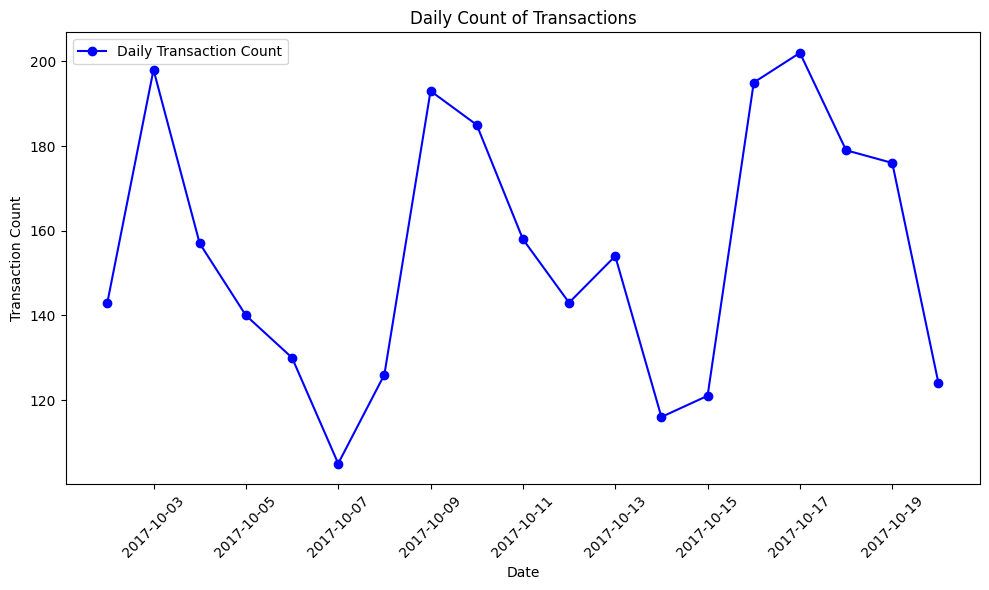

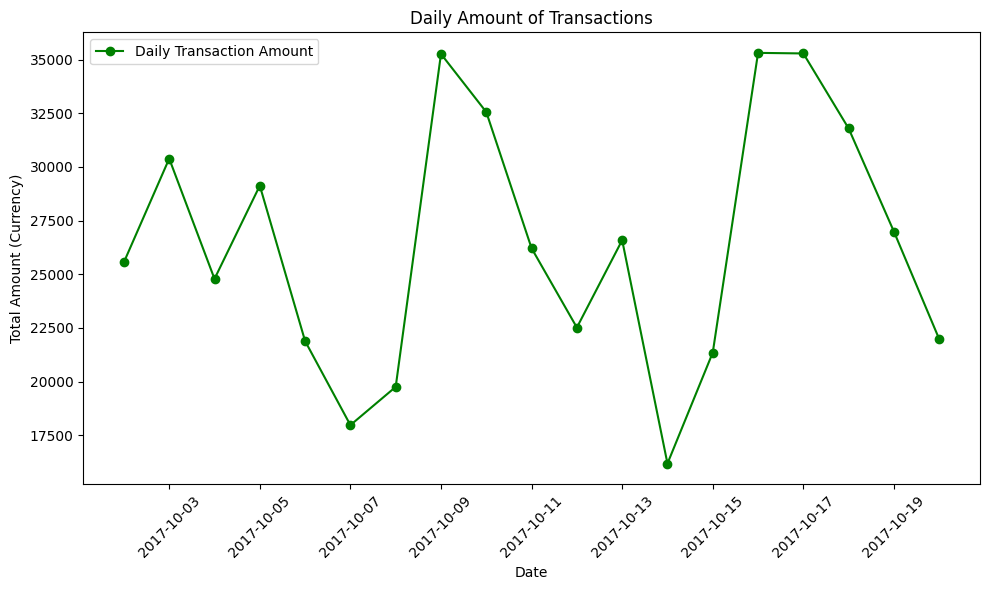

In [12]:
# 1. Grafik Line untuk Daily Transaction Count
plt.figure(figsize=(10, 6))
plt.plot(daily_transaction_df['date'], daily_transaction_df['transaction_count'], color='blue', marker='o', linestyle='-', label="Daily Transaction Count")
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.title("Daily Count of Transactions")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Grafik Line untuk Daily Transaction Amount
plt.figure(figsize=(10, 6))
plt.plot(daily_transaction_df['date'], daily_transaction_df['total_amount'], color='green', marker='o', linestyle='-', label="Daily Transaction Amount")
plt.xlabel("Date")
plt.ylabel("Total Amount (Currency)")
plt.title("Daily Amount of Transactions")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Pertanyaan 2:

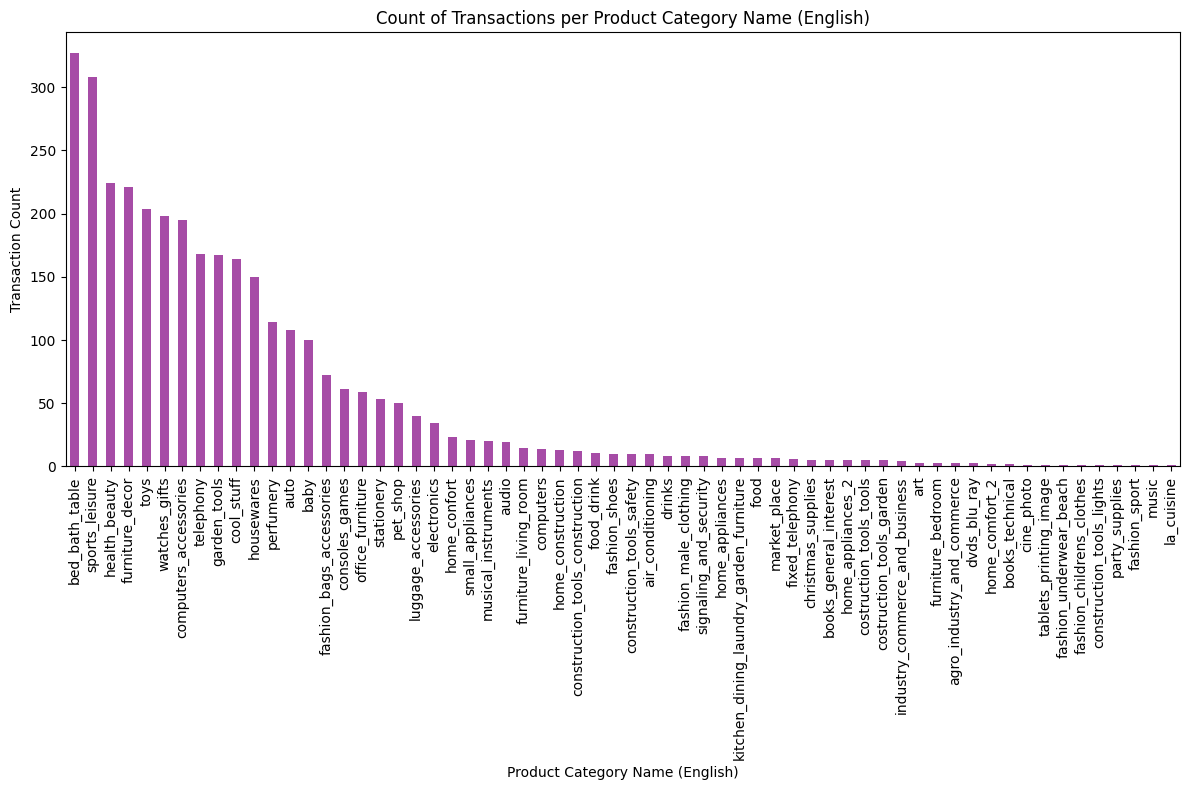

In [13]:
# 3. Grafik Bar untuk Count of Transactions per Product Category Name (English)
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar', color='purple', alpha=0.7)
plt.xlabel("Product Category Name (English)")
plt.ylabel("Transaction Count")
plt.title("Count of Transactions per Product Category Name (English)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Insight:**
- Performa penjualan pada e-commerce pada rentang waktu tertentu dapat terlihat pada grafik garis, dimana ada tren pada bulan tertentu penjualan meningkat pesat
- Hubungan antara suatu periode waktu terhadap kategori produk terjual ada, terlihat pada setip rentang waktu selalu ada produk yang lebih unggul

## Analisis Lanjutan (Opsional)

## Conclusion

- Performa penjualan pada e-commerce pada rentang waktu tertentu dapat terlihat pada grafik garis, dimana ada tren pada bulan tertentu penjualan meningkat pesat. Maka dapat dilakukan analisis untuk misalnya meluncurkan produk baru pada rentang waktu tersebut.
- Hubungan antara suatu periode waktu terhadap kategori produk terjual ada, terlihat pada setip rentang waktu selalu adapa produk yang lebih unggul. Maka dapat dilakukan analisis untuk misalnya menjadwalkan promo lebih pada produk yang kurang terjual
